In [4]:
import requests
import xlrd
import pandas as pd
import numpy as np
import json
import time as time_module 
import geopandas as gpd
import matplotlib.pyplot as plt
import polyline
from shapely.geometry import LineString, MultiLineString
from shapely.ops import linemerge
from collections import defaultdict
import math
from geopy.distance import geodesic
from shapely.ops import nearest_points
import folium
from folium import Element
import geopandas as gpd
import pandas as pd
from pprint import pprint
import os
import re
import glob
from dotenv import load_dotenv
from shapely.geometry import Point


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
os.environ['OGR_GEOMETRY_ACCEPT_UNCLOSED_RING'] = 'NO'

# Retrieving api key
load_dotenv("../key.env")
api_key = os.getenv("API_KEY")
TOKEN = os.getenv('ONEMAPTOKEN')

#### Reading in dataset

In [5]:
geospatial_train_path = "../datasets/geospatial_layer/TrainStation_Jul2024/RapidTransitSystemStation.shp"
train_stations = pd.read_excel("../datasets/Train_Stations.xls")
geospatial_train_gdf = gpd.read_file(geospatial_train_path)

In [6]:
%run get_bus_info_function.ipynb
bus_services_df = get_bus_info("https://datamall2.mytransport.sg/ltaodataservice/BusServices", api_key)
bus_routes_df = get_bus_info("https://datamall2.mytransport.sg/ltaodataservice/BusRoutes", api_key)
bus_stops_df = get_bus_info("https://datamall2.mytransport.sg/ltaodataservice/BusStops", api_key)

In [6]:
bus_routes_gdf = gpd.read_file('../datasets/routes/filtered_bus_routes.geojson')

#### Data Pre-processing

In [7]:
bus_routes_stops = pd.merge(bus_routes_df, bus_stops_df, on = "BusStopCode", how = 'left')
bus_routes_stops = bus_routes_stops.merge(
    bus_services_df[['ServiceNo', 'Category']],  # Select only the columns needed for merging
    on='ServiceNo',  # Merge on BusStopCode
    how='left'  # Use 'left' join to keep all rows from bus_routes_stops
)

In [8]:
# Drop duplicates and assign it back to the original DataFrame
bus_routes_stops = bus_routes_stops.drop_duplicates().reset_index(drop=True)

# Filter the DataFrame for rows with 'Category' equal to 'TRUNK'
bus_routes_stops = bus_routes_stops[bus_routes_stops['Category'] == 'TRUNK']

In [9]:
# Step 1: Union the geometries for the same station
unioned_gdf = geospatial_train_gdf.dissolve(by='STN_NAM_DE',aggfunc='first')

# Step 2: Calculate the centroid of the unioned polygon
unioned_gdf['centroid'] = unioned_gdf.centroid
unioned_gdf['geometry'] = unioned_gdf['centroid']

# Reset index to clean up
unioned_gdf.reset_index(inplace=True)

c:\Users\Gene\anaconda3\envs\DSA4264\Lib\site-packages\geopandas\geodataframe.py:1816: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union


In [10]:
# Function to normalize station names in train_stations_df
def normalize_station_name(name):
    return name.strip().upper()  # Ensure names are uppercase for consistent merging

# Apply normalization function to train_stations_df
train_stations['Normalized_Station'] = train_stations['MRT_Station'].apply(normalize_station_name)

# Create a column to append " MRT STATION" or " LRT STATION" based on the MRT_Line
train_stations['Station_MRT_LRT'] = train_stations.apply(
    lambda row: f"{row['Normalized_Station']} MRT STATION" if "LRT" not in row['MRT_Line'] else f"{row['Normalized_Station']} LRT STATION",
    axis=1
)

# Apply normalization to geospatial_train_df
# Strip ' MRT STATION' and ' LRT STATION' and normalize to uppercase
unioned_gdf['Normalized_Station'] = unioned_gdf['STN_NAM_DE'].str.strip().str.upper()

# Perform the merge on 'Station_MRT_LRT' from train_stations and 'Normalized_Station' from unioned_gdf
merged_train_stations = train_stations.merge(
    unioned_gdf,
    how='left',
    left_on='Station_MRT_LRT',
    right_on='Normalized_Station'
)

# Keeping necessary columns
columns_to_keep = ['Station_Code', 'MRT_Station', 'MRT_Line', 'TYP_CD_DES', 'geometry']
merged_train_stations = merged_train_stations[columns_to_keep]

# Check the resulting column names and sample data
print(merged_train_stations.head())


  Station_Code    MRT_Station           MRT_Line TYP_CD_DES  \
0          NS1    Jurong East  North-South Line         MRT   
1          NS2    Bukit Batok  North-South Line         MRT   
2          NS3   Bukit Gombak  North-South Line         MRT   
3          NS4  Choa Chu Kang  North-South Line         MRT   
4          NS5        Yew Tee  North-South Line         MRT   

                      geometry  
0  POINT (17866.487 35045.184)  
1  POINT (18676.448 36790.872)  
2  POINT (18940.178 37860.706)  
3  POINT (18101.056 40790.989)  
4  POINT (18438.643 42159.628)  


In [11]:
#  Convert Pandas DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(merged_train_stations, geometry='geometry')

#  Reproject the GeoDataFrame to EPSG:4326 (WGS 84 - latitude/longitude)
gdf_4326 = gdf.to_crs(epsg=4326)

# Extract Longitude and Latitude from the reprojected geometries
gdf_4326['Longitude'] = gdf_4326.geometry.x
gdf_4326['Latitude'] = gdf_4326.geometry.y

#  Convert back to a Pandas DataFrame (if you don't need the geometry anymore)
merged_train_stations = pd.DataFrame(gdf_4326)

# Removing redundant columns
columns_to_keep = ['Station_Code', 'MRT_Station', 'MRT_Line', 'Longitude', 'Latitude']
merged_train_stations = merged_train_stations[columns_to_keep]
merged_train_stations['Train_Line'] = merged_train_stations['Station_Code'].str.extract(r'([A-Za-z]+)')
merged_train_stations['Station_No'] = merged_train_stations['Station_Code'].str.extract(r'(\d+)').fillna(1).astype(int)
print(merged_train_stations.head())

  Station_Code    MRT_Station           MRT_Line   Longitude  Latitude  \
0          NS1    Jurong East  North-South Line   103.742263  1.333209   
1          NS2    Bukit Batok  North-South Line   103.749541  1.348997   
2          NS3   Bukit Gombak  North-South Line   103.751910  1.358672   
3          NS4  Choa Chu Kang  North-South Line   103.744369  1.385172   
4          NS5        Yew Tee  North-South Line   103.747402  1.397550   

  Train_Line  Station_No  
0         NS           1  
1         NS           2  
2         NS           3  
3         NS           4  
4         NS           5  


In [28]:
#  This is the train_lines gdf created in "./parallel_routes.ipynb" solely by constructing line strings between mrt stations
train_routes_gdf = gpd.read_file("../datasets/routes/train_lines.geojson")

In [30]:
# Convert bus stops (Pandas DataFrame) to GeoDataFrame with geometry points
bus_routes_stops_gdf = gpd.GeoDataFrame(
    bus_routes_stops,
    geometry=gpd.points_from_xy(bus_routes_stops['Longitude'], bus_routes_stops['Latitude']),
    crs="EPSG:4326"
)

### Method  V1

In [24]:
# Constants
DISTANCE_THRESHOLD = 350  # Distance in meters
ANGLE_THRESHOLD = 25  # Maximum angle in degrees for parallelness
CONSECUTIVE_WEIGHT = 1.2  # Weight multiplier for consecutive parallel stops

# Custom function to merge dictionaries
def merge_dicts(dicts):
    merged = defaultdict(list)
    for d in dicts:
        for key, value in d.items():
            if isinstance(value, dict):
                merged[key].append(value)
            else:
                merged[key].extend(value if isinstance(value, list) else [value])
    return dict(merged)

# Function to calculate angle between two points
def calculate_angle(bus_p1, bus_p2, train_p1, train_p2):
    bus_dx = bus_p1.x - bus_p2.x
    bus_dy = bus_p1.y - bus_p2.y
    bus_norm = math.sqrt(bus_dy ** 2 + bus_dx ** 2)
    
    train_dx = train_p1.x - train_p2.x
    train_dy = train_p1.y - train_p2.y
    train_norm = math.sqrt(train_dy ** 2 + train_dx ** 2)

    if bus_norm == 0 or train_norm == 0:
        return 0

    norm_dot_prod = (bus_dx * train_dx + bus_dy * train_dy) / (bus_norm * train_norm)
    angle = np.degrees(np.arccos(norm_dot_prod))

    if angle >= 90:
        angle = 180 - angle

    return angle

# Updated function to calculate parallelness with consecutive parallel segments and combine directions
def calculate_parallelness_combined_directions(bus_routes_stops_gdf, train_routes_gdf):
    parallel_scores = []

    # Group by ServiceNo and Direction to process each bus service route individually
    for service_no, service_data in bus_routes_stops_gdf.groupby('ServiceNo'):
        directions = service_data['Direction'].unique()

        # Process each direction
        for direction in directions:
            route_stops = service_data[service_data['Direction'] == direction]
            total_stops = len(route_stops)

            if total_stops < 2:
                continue

            train_line_parallel_data = {}
            total_parallel_count = 0
            consecutive_parallel_count = 0  # Tracks consecutive parallel segments

            # Process each MRT line to calculate both distance-based parallelness and angular similarity
            for mrt_line_id, mrt_line_geom in train_routes_gdf.set_index('Train_Line').geometry.items():
                parallel_stop_codes = []
                parallel_stop_coords = []
                line_parallel_count = 0  # Track count for this MRT line
                consecutive_segment_length = 0  # Length of the current consecutive parallel sequence

                for i in range(total_stops - 1):
                    bus_stop_geom1 = route_stops.iloc[i].geometry
                    bus_stop_geom2 = route_stops.iloc[i + 1].geometry
                    bus_stop_code = route_stops.iloc[i]['BusStopCode']

                    bus_segment = LineString([bus_stop_geom1, bus_stop_geom2])
                    segment_midpoint = bus_segment.interpolate(0.5, normalized=True)

                    # Distance and angle calculations
                    nearest_train_segment = mrt_line_geom.interpolate(mrt_line_geom.project(segment_midpoint))
                    nearest_train_point = mrt_line_geom.interpolate(mrt_line_geom.project(nearest_train_segment) + 0.01)
                    distance = geodesic((segment_midpoint.y, segment_midpoint.x), (nearest_train_segment.y, nearest_train_segment.x)).meters
                    angle_difference = calculate_angle(bus_stop_geom1, bus_stop_geom2, nearest_train_segment, nearest_train_point)

                    # Check parallel conditions and manage consecutive parallel segments
                    if distance <= DISTANCE_THRESHOLD and angle_difference <= ANGLE_THRESHOLD:
                        line_parallel_count += 1
                        parallel_stop_codes.append(bus_stop_code)
                        parallel_stop_coords.append((bus_stop_geom1.x, bus_stop_geom1.y))

                        # Track consecutive segments
                        consecutive_segment_length += 1
                    else:
                        # Apply weight if there was a consecutive parallel segment
                        if consecutive_segment_length > 1:
                            consecutive_parallel_count += consecutive_segment_length * CONSECUTIVE_WEIGHT
                        consecutive_segment_length = 0

                # Finalize consecutive parallel count for the last sequence
                if consecutive_segment_length > 1:
                    consecutive_parallel_count += consecutive_segment_length * CONSECUTIVE_WEIGHT

                # Store parallel stop details if any parallel stops found for this MRT line
                if parallel_stop_codes:
                    train_line_parallel_data[mrt_line_id] = {
                        'ParallelStopCodes': parallel_stop_codes,
                        'ParallelStopCoordinates': parallel_stop_coords,
                        'ParallelCount': line_parallel_count
                    }
                    total_parallel_count += line_parallel_count

            # Calculate a weighted score considering consecutive segments
            weighted_parallel_score = (total_parallel_count + consecutive_parallel_count) / total_stops if total_stops > 0 else 0

            parallel_scores.append({
                'ServiceNo': service_no,
                'Direction': direction,
                'TotalStops': total_stops,
                'WeightedParallelScore': weighted_parallel_score,
                'TrainLineParallelData': train_line_parallel_data
            })

    # Convert to DataFrame
    parallel_results_df = pd.DataFrame(parallel_scores)

    # Step 2: Aggregate by ServiceNo to combine directions
    aggregated_results = (
        parallel_results_df.groupby('ServiceNo')
        .agg({
            'TotalStops': 'sum',
            'WeightedParallelScore': 'mean',  # Average score across directions
            'TrainLineParallelData': merge_dicts  # Merge parallel data across directions
        })
        .reset_index()
    )

    # Sort by WeightedParallelScore for top results
    aggregated_results = aggregated_results.sort_values(by='WeightedParallelScore', ascending=False)

    return aggregated_results

# Run the function and display the top-ranked results aggregated by ServiceNo
final_results = calculate_parallelness_combined_directions(bus_routes_stops_gdf, train_routes_gdf)

In [63]:
# Constants
DISTANCE_THRESHOLD = 350  # Distance in meters
ANGLE_THRESHOLD = 25  # Maximum angle in degrees for parallelness
CONSECUTIVE_WEIGHT = 1.2  # Weight multiplier for longest consecutive parallel stops

# Custom function to merge dictionaries
def merge_dicts(dicts):
    merged = defaultdict(list)
    for d in dicts:
        for key, value in d.items():
            if isinstance(value, dict):
                merged[key].append(value)
            else:
                merged[key].extend(value if isinstance(value, list) else [value])
    return dict(merged)

# Function to calculate angle between two points
def calculate_angle(bus_p1, bus_p2, train_p1, train_p2):
    bus_dx = bus_p1.x - bus_p2.x
    bus_dy = bus_p1.y - bus_p2.y
    bus_norm = math.sqrt(bus_dy ** 2 + bus_dx ** 2)
    
    train_dx = train_p1.x - train_p2.x
    train_dy = train_p1.y - train_p2.y
    train_norm = math.sqrt(train_dy ** 2 + train_dx ** 2)

    if bus_norm == 0 or train_norm == 0:
        return 0

    norm_dot_prod = (bus_dx * train_dx + bus_dy * train_dy) / (bus_norm * train_norm)
    angle = np.degrees(np.arccos(norm_dot_prod))

    if angle >= 90:
        angle = 180 - angle
    return angle

# Updated function to calculate parallelness with tracking of unique stops and longest consecutive sequence
def calculate_parallelness_combined_directions(bus_routes_stops_gdf, train_routes_gdf):
    parallel_scores = []

    # Group by ServiceNo and Direction to process each bus service route individually
    for service_no, service_data in bus_routes_stops_gdf.groupby('ServiceNo'):
        directions = service_data['Direction'].unique()

        # Process each direction
        for direction in directions:
            route_stops = service_data[service_data['Direction'] == direction]
            total_stops = len(route_stops)

            if total_stops < 2:
                continue

            train_line_parallel_data = {}
            unique_parallel_stops = set()  # Set to track unique parallel stops
            longest_consecutive_length = 0  # Track the longest consecutive sequence

            # Process each MRT line to calculate both distance-based parallelness and angular similarity
            for mrt_line_id, mrt_line_geom in train_routes_gdf.set_index('Train_Line').geometry.items():
                current_consecutive_length = 0  # Track the current consecutive sequence length
                parallel_stop_codes = []  # List to track parallel stop codes for this MRT line

                for i in range(total_stops - 1):
                    bus_stop_geom1 = route_stops.iloc[i].geometry
                    bus_stop_geom2 = route_stops.iloc[i + 1].geometry
                    bus_stop_code = route_stops.iloc[i]['BusStopCode']

                    bus_segment = LineString([bus_stop_geom1, bus_stop_geom2])
                    segment_midpoint = bus_segment.interpolate(0.5, normalized=True)

                    # Distance and angle calculations
                    nearest_train_segment = mrt_line_geom.interpolate(mrt_line_geom.project(segment_midpoint))
                    nearest_train_point = mrt_line_geom.interpolate(mrt_line_geom.project(nearest_train_segment) + 0.01)
                    distance = geodesic((segment_midpoint.y, segment_midpoint.x), (nearest_train_segment.y, nearest_train_segment.x)).meters
                    angle_difference = calculate_angle(bus_stop_geom1, bus_stop_geom2, nearest_train_segment, nearest_train_point)

                    # Check parallel conditions and manage consecutive parallel segments
                    if distance <= DISTANCE_THRESHOLD and angle_difference <= ANGLE_THRESHOLD:
                        unique_parallel_stops.add(bus_stop_code)
                        parallel_stop_codes.append(bus_stop_code)
                        current_consecutive_length += 1
                    else:
                        # Update the longest consecutive sequence if needed
                        if current_consecutive_length > longest_consecutive_length:
                            longest_consecutive_length = current_consecutive_length
                        current_consecutive_length = 0

                # Finalize consecutive length for the last sequence in this MRT line
                if current_consecutive_length > longest_consecutive_length:
                    longest_consecutive_length = current_consecutive_length

                # Append the data for the current MRT line to the parallel data dictionary
                if mrt_line_id not in train_line_parallel_data:
                    train_line_parallel_data[mrt_line_id] = {
                        'ParallelStopCount': len(parallel_stop_codes),
                        'ParallelStopCodes': parallel_stop_codes
                    }

            # Calculate the weighted parallel score with unique stops and longest consecutive sequence
            weighted_parallel_score = (
                (len(unique_parallel_stops) + (longest_consecutive_length * CONSECUTIVE_WEIGHT)) / total_stops
                if total_stops > 0 else 0
            )

            parallel_scores.append({
                'ServiceNo': service_no,
                'Direction': direction,
                'TotalStops': total_stops,
                'WeightedParallelScore': weighted_parallel_score,
                'TrainLineParallelData': train_line_parallel_data,
                'UniqueParallelStopsCount': len(unique_parallel_stops),
                'LongestConsecutiveLength': longest_consecutive_length
            })

    # Convert to DataFrame
    parallel_results_df = pd.DataFrame(parallel_scores)

    # Step 2: Aggregate by ServiceNo to combine directions
    aggregated_results = (
        parallel_results_df.groupby('ServiceNo')
        .agg({
            'TotalStops': 'sum',
            'WeightedParallelScore': 'mean',  # Average score across directions
            'TrainLineParallelData': merge_dicts,  # Merge parallel data across directions
            'UniqueParallelStopsCount': 'sum',  # Total unique stops across directions
            'LongestConsecutiveLength': 'max'  # Max consecutive length across directions
        })
        .reset_index()
    )

    # Sort by WeightedParallelScore for top results
    aggregated_results = aggregated_results.sort_values(by='WeightedParallelScore', ascending=False)

    return aggregated_results

# Run the function and display the top-ranked results aggregated by ServiceNo
final_results = calculate_parallelness_combined_directions(bus_routes_stops_gdf, train_routes_gdf)


In [65]:
print(final_results.head(20))

    ServiceNo  TotalStops  WeightedParallelScore  \
254        67         163               1.181314   
358      965A          15               1.160000   
159         2         131               1.070266   
197       36A          33               1.036364   
219        48         105               1.032547   
113       170         130               1.012027   
278        7A          35               1.005714   
243       60A          10               0.980000   
299      856A           7               0.942857   
12        107          79               0.939744   
176        26          64               0.939020   
198       36B          51               0.921569   
399        9A          21               0.866667   
77       147A          47               0.863830   
338      925A          18               0.855556   
54        133          86               0.854870   
196        36          61               0.839344   
13       107M          68               0.826471   
326      883

In [67]:
# Filter the final results to exclude ServiceNos with alphabetic characters
filtered_final_results = final_results[~final_results['ServiceNo'].str.contains(r'[A-Za-z]')]

# Display filtered results
print(filtered_final_results[['ServiceNo', 'TotalStops', 'UniqueParallelStopsCount','WeightedParallelScore','LongestConsecutiveLength', 'TrainLineParallelData']].head(50))

    ServiceNo  TotalStops  UniqueParallelStopsCount  WeightedParallelScore  \
254        67         163                       135               1.181314   
159         2         131                        73               1.070266   
219        48         105                        76               1.032547   
113       170         130                        74               1.012027   
12        107          79                        49               0.939744   
176        26          64                        29               0.939020   
54        133          86                        46               0.854870   
196        36          61                        38               0.839344   
169        24         100                        55               0.742000   
76        147         146                        72               0.740808   
0          10         148                        73               0.736486   
141       188         111                        48             

In [68]:
filtered_final_results.to_csv('../datasets/filtered_final_results4.csv')

#### Sensitivity Analysis for Consecutive Weight

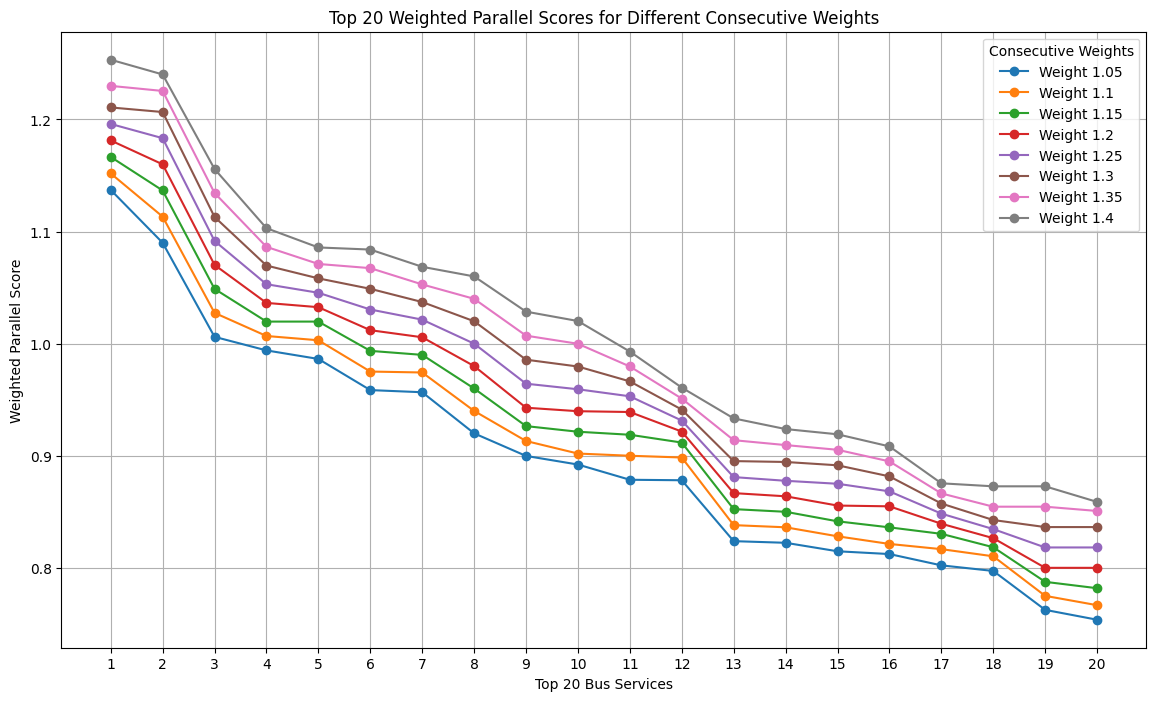

In [47]:
import matplotlib.pyplot as plt

# List of consecutive weights to test
consecutive_weights = [1.05, 1.1, 1.15, 1.2, 1.25, 1.3,1.35,1.4]

# Dictionary to store the top 20 weighted parallel scores for each consecutive weight
sensitivity_results = {}

# Iterate through the list of consecutive weights and calculate the scores
for weight in consecutive_weights:
    global CONSECUTIVE_WEIGHT
    CONSECUTIVE_WEIGHT = weight  # Update the global weight
    results = calculate_parallelness_combined_directions(bus_routes_stops_gdf, train_routes_gdf)
    
    # Get the top 20 results based on WeightedParallelScore
    top_20_results = results.sort_values(by='WeightedParallelScore', ascending=False).head(20)
    
    # Store the top 20 scores in the dictionary
    sensitivity_results[weight] = top_20_results['WeightedParallelScore'].values

# Plot the sensitivity analysis results for the top 20 parallel scores
plt.figure(figsize=(14, 8))

# Plot each consecutive weight's top 20 parallel scores as a line
for weight in consecutive_weights:
    plt.plot(
        range(1, 21), 
        sensitivity_results[weight], 
        marker='o', 
        linestyle='-', 
        label=f'Weight {weight}'
    )

plt.title('Top 20 Weighted Parallel Scores for Different Consecutive Weights')
plt.xlabel('Top 20 Bus Services')
plt.ylabel('Weighted Parallel Score')
plt.xticks(range(1, 21))
plt.grid(True)
plt.legend(title='Consecutive Weights')
plt.show()


#### Plotting top 3 bus service routes

In [18]:
bus_geo_data = gpd.read_file('../datasets/routes/routes.min.geojson')

In [ ]:
train_routes_gdf

In [ ]:
merged_train_stations.head()

In [19]:
# Get the top 3 bus routes by some criteria (e.g., WeightedParallelScore)
top_3_bus_routes = bus_geo_data[bus_geo_data['number'].isin(['67', '111', '36'])]

# Colors for the top 3 bus services and their directions
bus_colors = [
    ('pink', 'lightcoral'),  # Service 1: Direction 1, Direction 2
    ('cyan', 'lightblue'),     # Service 2: Direction 1, Direction 2
    ('purple', 'plum')         # Service 3: Direction 1, Direction 2
]

# Define color mapping for each MRT line
color_map = {
    'TE': 'brown',
    'EW': 'green',
    'CC': '#FFA500',  # Yellowish orange
    'NE': 'purple',
    'NS': 'red',
    'DT': 'blue',
    'SK': 'grey',
    'BP': 'grey',
    'PG': 'grey',
    'CE': 'orange',
    'CG' : 'grey'
}

mrt_map = {
    'TE': 'Thomson East-Coast Line',
    'EW': 'East-West Line',
    'CC': 'Circle Line',  # Yellowish orange
    'NE': 'North-East Line',
    'NS': 'North-South Line',
    'DT': 'Downtown Line',
    'SK': 'SENG KANG LRT',
    'BP': 'BUKIT PANJANG LRT',
    'PG': 'PUNGGOL LRT',
    'CE': 'Circle Line Extension',
    'CG' : 'Changi Airport Branch'
}


# Function to apply an offset to the coordinates of a LineString
def offset_line(line, offset=0.0001):
    """
    Applies an offset to the coordinates of a LineString.
    Args:
        line (LineString): The original LineString.
        offset (float): The offset value to apply to the coordinates.
    Returns:
        LineString: The new LineString with applied offset.
    """
    new_coords = [(x + offset, y + offset) for x, y in line.coords]
    return LineString(new_coords)


# Function to create a legend
def add_mrt_legend(map_object, color_map, mrt_map, bus_number):
    legend_html = f'''
     <div style="
     position: fixed;
     bottom: 50px;
     left: 50px;
     width: 220px;
     height: auto;
     z-index:9999;
     font-size:14px;
     background-color: white;
     padding: 10px;
     border: 2px solid black;
     ">
     <b>Bus Service {bus_number}</b><br><br>
     <b>Legend for MRT Lines:</b><br><br>
    '''
    for line_code, color in color_map.items():
        if line_code in mrt_map:  # Only add MRT lines that are in mrt_map
            line_name = mrt_map[line_code]
            legend_html += f'<i style="background:{color}; width: 10px; height: 10px; display: inline-block; margin-right: 5px;"></i> {line_name}<br>'
    
    legend_html += '</div>'
    
    map_object.get_root().html.add_child(Element(legend_html))

# Create three separate maps for each bus service
for i, bus_number in enumerate(['67', '111', '36']):
    # Create a base Folium map centered around Singapore
    sg_map = folium.Map(location=[1.3521, 103.8198], zoom_start=12, tiles='CartoDB positron')
    
    # Plot all train lines in grey
    for _, row in train_routes_gdf.iterrows():
        if isinstance(row['geometry'], LineString):
            train_line = row['Train_Line']
            long_name = mrt_map.get(train_line, 'Unknown Line')
            color = color_map.get(train_line, 'black')  # Default to 'black' if not found in the color map
            coords = [(point[1], point[0]) for point in row['geometry'].coords]  # Switch (lon, lat) to (lat, lon)
            folium.PolyLine(
                locations=coords,
                color=color,
                weight=2,
                opacity=0.5,
                popup=f"{long_name}"
            ).add_to(sg_map)
    # Add MRT stations as CircleMarkers
    for _, station_row in merged_train_stations.iterrows():
        line_code = station_row['Station_Code'][:2]  # Adjust this as needed based on your data structure
        station_color = color_map.get(line_code, 'grey')
        folium.CircleMarker(
            location=(station_row['Latitude'], station_row['Longitude']),
            radius=4,
            color=station_color,
            fill=True,
            fill_color=station_color,
            fill_opacity=0.7,
            popup=f"{station_row['Station_Code']}<br>{station_row['MRT_Station']}",
            tooltip=f"{station_row['Station_Code']} - {station_row['MRT_Station']}"
        ).add_to(sg_map)

    # Filter the routes for the current bus number
    bus_routes = top_3_bus_routes[top_3_bus_routes['number'] == bus_number]
    
    # Plot the bus stops associated with the current bus number
    bus_stops = bus_routes_stops_gdf[bus_routes_stops_gdf['ServiceNo'] == bus_number]
    for _, stop_row in bus_stops.iterrows():
        folium.CircleMarker(
            location=(stop_row['Latitude'], stop_row['Longitude']),
            radius=3,  # Adjust the radius as needed for better visualization
            color='black',  # Color of the circle's outline
            fill=True,
            fill_color='black',  # Color of the filled circle
            fill_opacity=0.7,
            popup=f"{stop_row['BusStopCode']}<br>{stop_row['Description']}",
            tooltip=f"{stop_row['BusStopCode']} - {stop_row['Description']}"
        ).add_to(sg_map)

    # Check if both directions exist
    if not bus_routes[bus_routes['pattern'] == 0].empty:
        bus_line_1 = bus_routes[bus_routes['pattern'] == 0]['geometry'].values[0]
        service_name_1 = f"{bus_number}_direction_1"
        color_1 = bus_colors[i][0]

        # Offset and plot direction 1
        offset_line_1 = offset_line(bus_line_1, offset=0.0001)
        folium.PolyLine(
            locations=[(lat, lon) for lon, lat in offset_line_1.coords],
            color=color_1,
            weight=5,
            opacity=0.8,
            tooltip=service_name_1
        ).add_to(sg_map)
    else:
        print(f"No data for {bus_number} direction 1")

    if not bus_routes[bus_routes['pattern'] == 1].empty:
        bus_line_2 = bus_routes[bus_routes['pattern'] == 1]['geometry'].values[0]
        service_name_2 = f"{bus_number}_direction_2"
        color_2 = bus_colors[i][1]

        # Offset and plot direction 2
        offset_line_2 = offset_line(bus_line_2, offset=-0.0001)
        folium.PolyLine(
            locations=[(lat, lon) for lon, lat in offset_line_2.coords],
            color=color_2,
            weight=5,
            opacity=0.8,
            tooltip=service_name_2
        ).add_to(sg_map)
    else:
        print(f"No data for {bus_number} direction 2")

    add_mrt_legend(sg_map, color_map, mrt_map, bus_number)
    sg_map.save(f'../datasets/routes/map_bus_service_{i + 1}.html')
    sg_map

# The maps will be saved as HTML files: map_bus_service_1.html, map_bus_service_2.html, map_bus_service_3.html


No data for 111 direction 2
No data for 36 direction 2
